In [377]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm

In [378]:
#loading the data and loosing all Null values
df = pd.read_csv(r'framingham_heart_disease.csv')
df = df[['male','BMI']]
original_size = df.shape[0]
df.dropna(how='any', inplace=True)
no_null_size = df.shape[0]
df.insert(loc=0,column='intercept',value=1)
print(f'Data size after dropping Null values is'
      f' {no_null_size/original_size * 100:0.3}% of the original data size')

Data size after dropping Null values is 99.6% of the original data size


In [379]:
def generate_sample(df, size):
    np.random.seed(4861351)
    flag = True
    sample = None
    while flag: #will take another sample if there is one sex only
        sample = df.sample(size)
        female_count,male_count = sample[['male', 'BMI']].groupby('male').count()['BMI']
        if female_count != 0 and male_count != 0 :
            if abs(female_count - male_count) <= size*0.1:
                flag = False
            else:
                flag = True
    return sample

In [380]:
sample_200 = generate_sample(df, 200)

new_df = df.merge(sample_200, how='left', indicator=True)
new_df = new_df[new_df['_merge'] == 'left_only']
sample_1000 = generate_sample(new_df,1000)
sample_1000['Z']=sample_1000['BMI'].apply( lambda x :1 if x > x_threashold else 0)

In [381]:
x_records = np.array(sample_1000['BMI'])
x_threashold = np.quantile(x_records,0.5)
sample_200['Z']=sample_200['BMI'].apply( lambda x :1 if x > x_threashold else 0)


In [382]:
def etha(p):
    return np.log(p/(1-p))
def calculate_psi(data):
    p1_hat = np.average(data[data['male']==1]['Z'])
    p0_hat = np.average(data[data['male']==0]['Z'])

    etha1_hat = etha(p1_hat)
    etha0_hat = etha(p0_hat)
    return etha1_hat - etha0_hat
psi_hat = calculate_psi(sample_200)
psi_hat

0.5745414381520988

Q2.a

Text(0.5, 1.0, 'Normal QQ plot for female BMI')

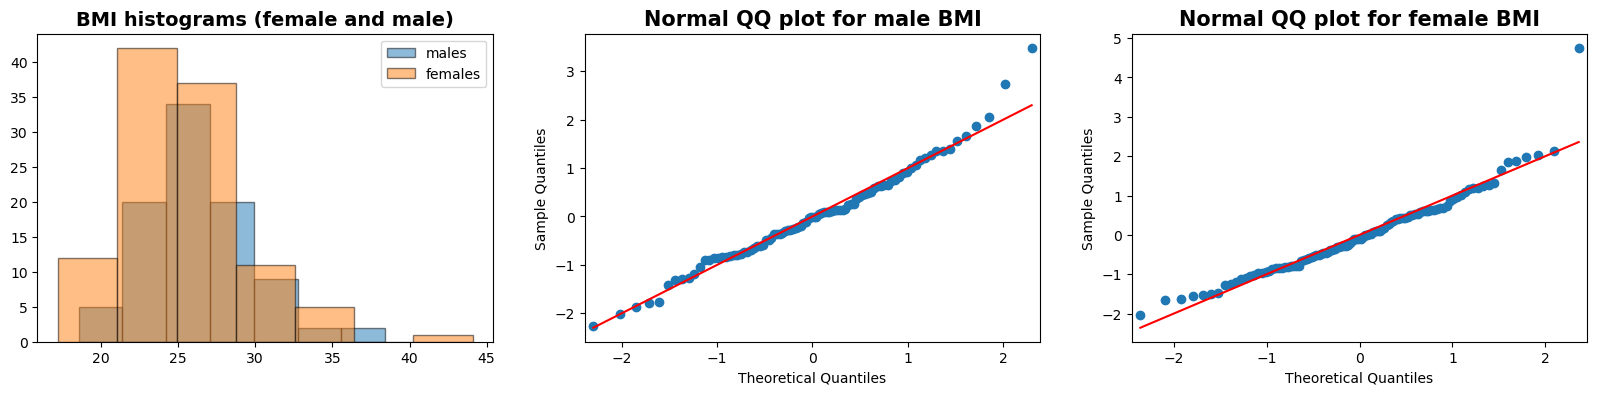

In [383]:
#2.a
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,4))
sample_200[sample_200['male']==1]['BMI'].hist(edgecolor = "black", grid = False, 
                                              alpha = 0.5, label = "males", ax = ax1, bins=7)
sample_200[sample_200['male']==0]['BMI'].hist(edgecolor = "black", grid = False, 
                                              alpha = 0.5, label = "females", ax = ax1, bins=7)
ax1.set_title("BMI histograms (female and male)", fontweight = "bold", fontsize = 14)
ax1.legend()

qqplot(sample_200[sample_200['male']==1]['BMI'],norm,fit=True,line="s",ax=ax2)
ax2.set_title("Normal QQ plot for male BMI", fontsize = 15, fontweight = "bold")
qqplot(sample_200[sample_200['male']==0]['BMI'],norm,fit=True,line="s", ax=ax3)
ax3.set_title("Normal QQ plot for female BMI", fontsize = 15, fontweight = "bold")

As we can see, the data distribution is Normal, so we can

In [384]:
B=1000
psi_bootstrap = np.array([calculate_psi(sample_200.sample(sample_200.shape[0],
                                                          replace=True)) for _ in range(B)])
psi_bootstrap_sd = np.std(psi_bootstrap)
print(f'The bootstrap estimator to the standard deviation of psi = {psi_bootstrap_sd:.03}')

The bootstrap estimator to the standard deviation of psi = 0.294


In [385]:
bootstrap_quantile = np.quantile(psi_bootstrap, [0.025, 0.975])
CI_normal = np.round([psi_hat - 1.96* psi_bootstrap_sd , psi_hat + 1.96* psi_bootstrap_sd],3)
CI_pivotal = np.round([2*psi_hat - bootstrap_quantile[1], 2*psi_hat - bootstrap_quantile[0]],3)
CI_quantiles = np.round(bootstrap_quantile,3)
print(f'CI with CL of 0.95 based on normal approximation  is {CI_normal}')
print(f'CI based on pivotal is {CI_pivotal}')
print(f'CI based on quantiles is {CI_quantiles}')

CI with CL of 0.95 based on normal approximation  is [-1.000e-03  1.151e+00]
CI based on pivotal is [0.006 1.14 ]
CI based on quantiles is [0.01  1.143]


Q2.b

In [386]:
#2.b - uniform prior of p
#p1|Xn ~ Beta(S1+1,n1-S1+1) - male
#p0|Xn ~ Beta(S0+1,n0-S0+1) - female
B=1000
psi_bootstrap_array = []
n1 = sample_200[sample_200['male']==1]['Z'].size
n0 = sample_200[sample_200['male']==0]['Z'].size
s1 = sample_200[sample_200['male']==1]['Z'].sum()
s0 = sample_200[sample_200['male']==0]['Z'].sum()
for _ in range(B):
    p1 = np.random.beta(s1+1,n1-s1+1,1)
    p0 = np.random.beta(s0+1,n0-s0+1,1)
    psi = etha(*p1) - etha(*p0)
    psi_bootstrap_array.append(psi)
psi_est = np.average(psi_bootstrap_array)
bootstrap_quantile = np.quantile(psi_bootstrap_array, [0.025, 0.975])
flat_CI_quantiles = np.round(bootstrap_quantile,3)
flat_CI_length = flat_CI_quantiles[1]-flat_CI_quantiles[0]
print(f'CI based on quantiles is {flat_CI_quantiles}')
print(f'CI length is {flat_CI_length}')


CI based on quantiles is [0.024 1.09 ]
CI length is 1.066


Q2.c

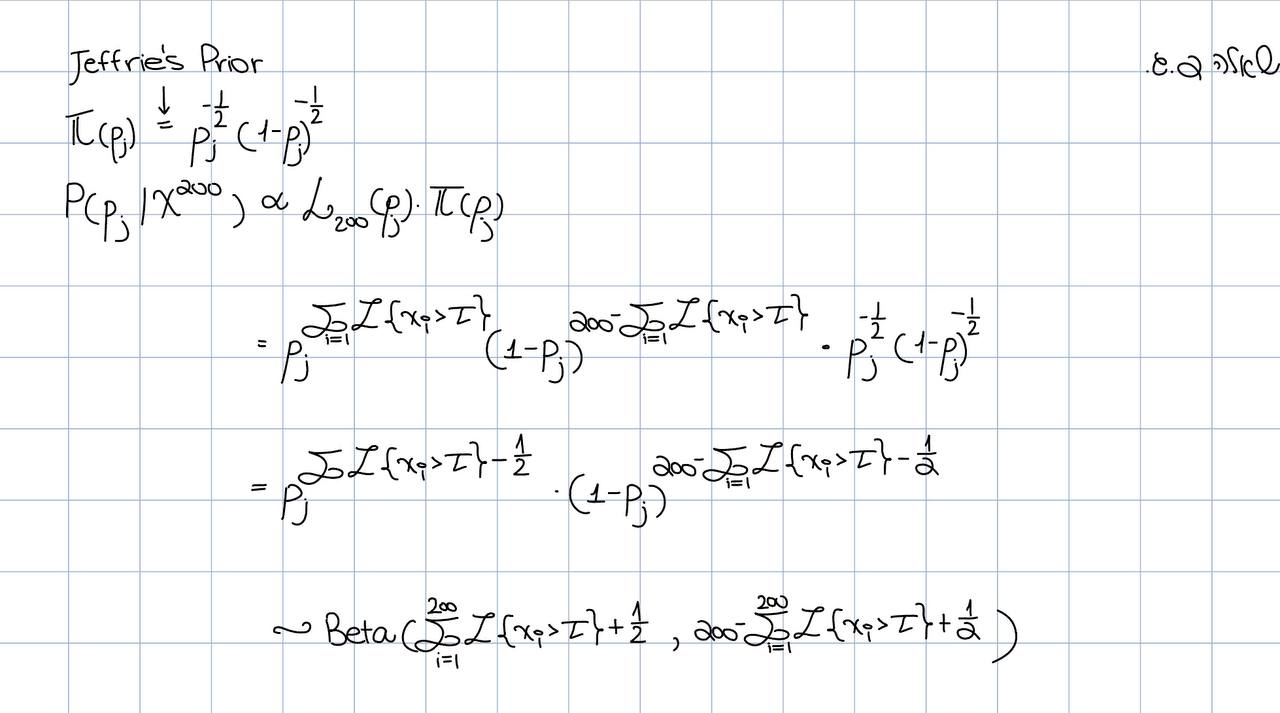

In [387]:
from IPython import display
display.Image('jeffreys prior.jpeg')

In [388]:
#2.c - Jeffreys' prior of p
#p1|Xn ~ Beta(S1+0.5,n1-S1+0.5) - male
#p0|Xn ~ Beta(S0+0.5,n0-S0+0.5) - female
#the distribution of p is the same from the example in lecture #5, week 5
B=1000
psi_bootstrap_array = []
n1 = sample_200[sample_200['male']==1]['Z'].size
n0 = sample_200[sample_200['male']==0]['Z'].size
s1 = sample_200[sample_200['male']==1]['Z'].sum()
s0 = sample_200[sample_200['male']==0]['Z'].sum()
for _ in range(B):
    p1 = np.random.beta(s1+0.5,n1-s1+0.5,1)
    p0 = np.random.beta(s0+0.5,n0-s0+0.5,1)
    psi = etha(*p1) - etha(*p0)
    psi_bootstrap_array.append(psi)
psi_est = np.average(psi_bootstrap_array)
bootstrap_quantile = np.quantile(psi_bootstrap_array, [0.025, 0.975])
jeffreys_CI_quantiles = np.round(bootstrap_quantile,3)
jeffreys_CI_length = jeffreys_CI_quantiles[1]-jeffreys_CI_quantiles[0]
print(f'CI based on quantiles is {jeffreys_CI_quantiles}')
print(f'CI length is {jeffreys_CI_length}')

CI based on quantiles is [0.033 1.133]
CI length is 1.1


Q2.d

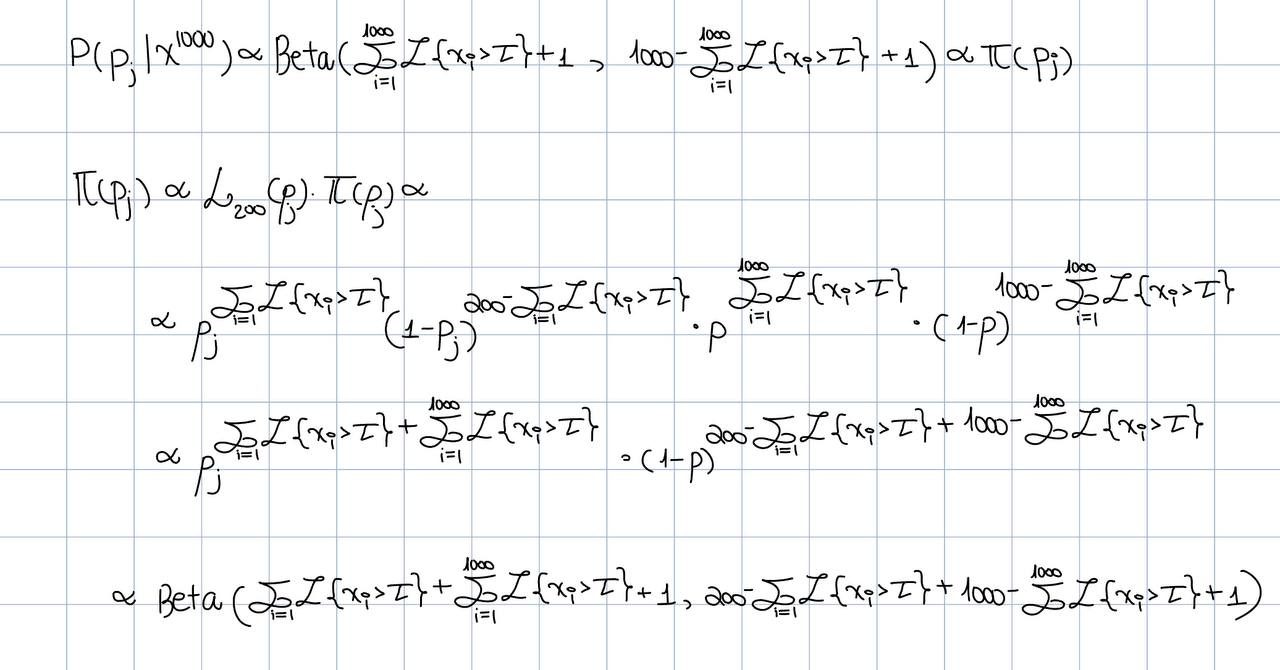

In [389]:
display.Image('1000prior.jpg')

In [390]:
n1_1000 = sample_1000[sample_1000['male']==1]['Z'].size
n0_1000 = sample_1000[sample_1000['male']==0]['Z'].size
s1_1000 = sample_1000[sample_1000['male']==1]['Z'].sum()
s0_1000 = sample_1000[sample_1000['male']==0]['Z'].sum()
print(f'prior male ~ Beta({s1_1000+1},{n1_1000-s1_1000+1})')
print(f'prior female ~ Beta({s0_1000+1},{n0_1000-s0_1000+1})')
n1_200 = sample_200[sample_200['male']==1]['Z'].size
n0_200 = sample_200[sample_200['male']==0]['Z'].size
s1_200 = sample_200[sample_200['male']==1]['Z'].sum()
s0_200 = sample_200[sample_200['male']==0]['Z'].sum()
B=1000
psi_bootstrap_array = []
for _ in range(B):
    p1 = np.random.beta(s1_200+s1_1000+1,(n1_1000-s1_1000)+(n1_200-s1_200)+1,1)
    p0 = np.random.beta(s0_200+s0_1000+1,(n0_1000-s0_1000)+(n0_200-s0_200)+1,1)
    psi = etha(*p1) - etha(*p0)
    psi_bootstrap_array.append(psi)
psi_est = np.average(psi_bootstrap_array)
bootstrap_quantile = np.quantile(psi_bootstrap_array, [0.025, 0.975])
beta_CI_quantiles = np.round(bootstrap_quantile,3)
beta_CI_length = beta_CI_quantiles[1]-beta_CI_quantiles[0]
print(f'CI based on quantiles is {beta_CI_quantiles}')
print(f'CI length is {beta_CI_length}')


prior male ~ Beta(258,196)
prior female ~ Beta(243,307)
CI based on quantiles is [0.293 0.748]
CI length is 0.455


Q2.e

In [391]:
print(f'flat based prior: {flat_CI_quantiles}, length is {flat_CI_length}')
print(f'jeffreys based prior: {jeffreys_CI_quantiles}, length is {jeffreys_CI_length}')
print(f'Beta(past samples) based prior: {beta_CI_quantiles}, length is {beta_CI_length}')


flat based prior: [0.024 1.09 ], length is 1.066
jeffreys based prior: [0.033 1.133], length is 1.1
Beta(past samples) based prior: [0.293 0.748], length is 0.455


Based on the credible interval lengths we will choose the estimator of psi based on the 1000 'past-knowledge' samples.
We know from the lectures that the narrowest credible interval is more suitable.

PART 2